# Apuntes de Copernicus API - Evolución del embalse de El Pardo.

Con el NDWI quiero hacer una evolución del nivel del embalse a lo largo de 1 año. 

# Importaciones y autenticación

In [21]:
import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    SHConfig,
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# Si no tienes utils.py ver Intro_True_Color.ipynb
from utils import plot_image

In [22]:
config = SHConfig(
  instance_id='',
  sh_client_id='sh-528927c0-6d64-433b-93da-e2a2ee8274e4',
  sh_client_secret='RwUkYG8qZSox9NNRLl0jpoZ8F9ZUnRTP',
  sh_base_url='https://sh.dataspace.copernicus.eu',
  sh_auth_base_url=None,
  sh_token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
  geopedia_wms_url='https://service.geopedia.world',
  geopedia_rest_url='https://www.geopedia.world/rest',
  aws_access_key_id='',
  aws_secret_access_key='',
  aws_session_token='',
  aws_metadata_url='https://roda.sentinel-hub.com',
  aws_s3_l1c_bucket='sentinel-s2-l1c',
  aws_s3_l2a_bucket='sentinel-s2-l2a',
  opensearch_url='http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2',
  max_wfs_records_per_query=100,
  max_opensearch_records_per_query=500,
  max_download_attempts=4,
  download_sleep_time=5.0,
  download_timeout_seconds=120.0,
  number_of_download_processes=1,
)

# Monte de El Pardo

In [23]:
pardo_wgs84 = (-3.851949,40.513817,-3.723203,40.617358)

resolution = 10 # metros
pardo_bbox = BBox(bbox=pardo_wgs84, crs=CRS.WGS84) # Importante el crs si se usa otro
pardo_size = bbox_to_dimensions(pardo_bbox, resolution=resolution)

print(f"Tamaño de la imagen en {resolution} m resolución: {pardo_size} pixeles")

Tamaño de la imagen en 10 m resolución: (1100, 1140) pixeles


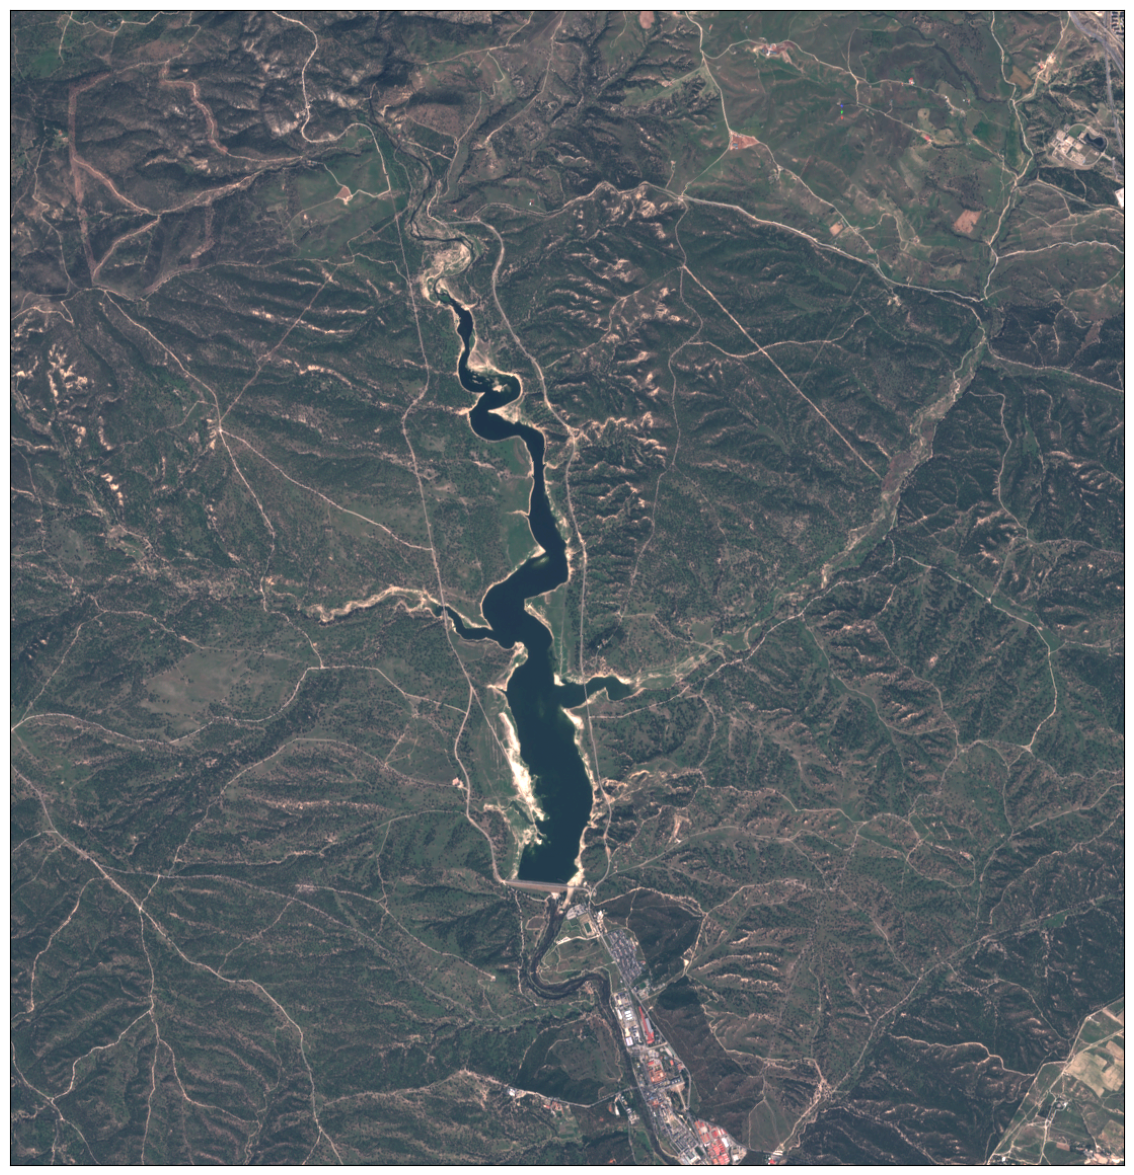

In [24]:
# Evalscript:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

pardo_sin_nubes = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url
            ),
            time_interval=("2023-03-01", "2023-03-30"), # Intervalo de un mes, lo pongo en 2022 pq en 2023 se ve oscuro
            mosaicking_order=MosaickingOrder.LEAST_CC, # Que elija la que menos nubes tenga
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=pardo_bbox,
    size=pardo_size,
    config=config,
)

# Como ya sabemos las dimensiones de la imagen que nos puede dar, hacemos el plot directamente
plot_image(pardo_sin_nubes.get_data()[0], factor=4/ 255, clip_range=(0, 1))

He cogido el embalse un poco más de cerca para que se vea mejor. Además de que he cogido el 2023 esta vez.

# NDWI - Sacamos el índice para 2023

 ## Evalscript y Request:


In [25]:
# Evalscript:
evalscript_ndwi = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B03", "B08"] // Green & NIR
            }],
            output: {
                bands: 2
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B03, sample.B08];
    }
"""

ndwi_request = SentinelHubRequest(
    evalscript=evalscript_ndwi,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url
            ),
            time_interval=("2023-03-01", "2023-03-30"), # Intervalo de un mes, lo pongo en 2022 pq en 2023 se ve oscuro
            mosaicking_order=MosaickingOrder.LEAST_CC, # Que elija la que menos nubes tenga
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=pardo_bbox,
    size=pardo_size,
    config=config,
)

In [26]:
ndwi_array = ndwi_request.get_data()

## Visualizamos el NDWI

In [27]:
image = ndwi_array[0] 

# Extraer las bandas
Green = image[:, :, 0]  
NIR = image[:, :, 1]  

# Calcular el NDWI
ndwi = (Green - NIR) / (Green + NIR)

#Creamos una mascara para delimitar las zonas de agua
mask = ndwi < 1
ndwi_masked = np.where(mask, ndwi, np.nan)
ndwi_imasked = np.where(~mask, ndwi, np.nan)

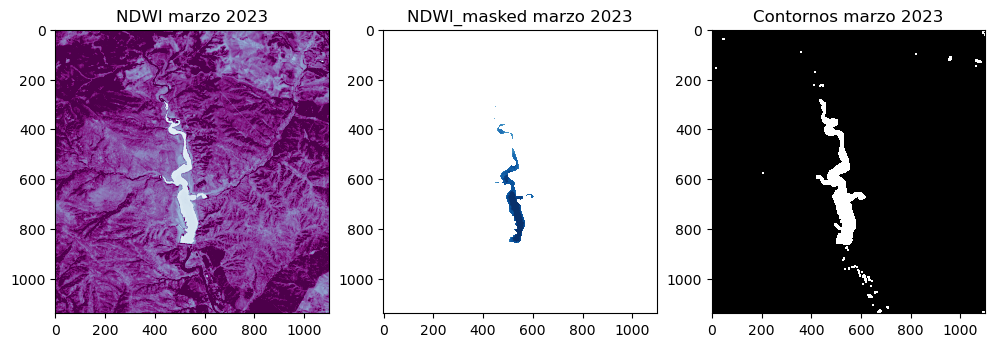

In [28]:
# Crear el plot del NDWI
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].imshow(ndwi, cmap='BuPu', vmax = 3)
axes[0].set_title('NDWI marzo 2023')
axes[1].imshow(ndwi_masked, cmap='Blues', vmax = .5)
axes[1].set_title('NDWI_masked marzo 2023')
axes[2].imshow(ndwi_imasked, cmap='grey', vmax = 1)
axes[2].set_title('Contornos marzo 2023')

plt.show()

    Nota: En los contronos me está viendo como agua pixeles sueltos. Esto lo voy a solucionar en el script de abajo poniendo un área minima para incluir en NDWI final

## Sacamos al máscara y calculamos el área

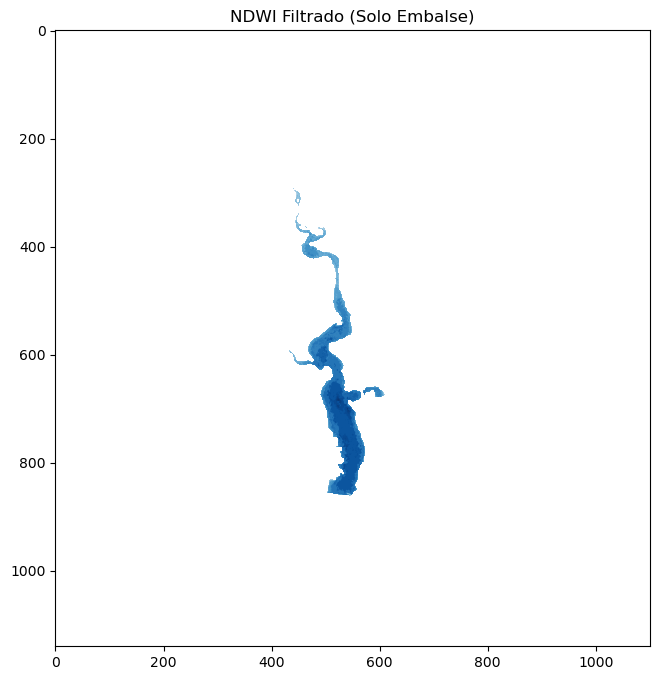

In [29]:
from skimage import measure, morphology

# Crear una máscara para delimitar las zonas de agua
mask = ndwi < 1
ndwi_masked = np.where(mask, ndwi, np.nan)

# Etiquetar los objetos en la imagen binarizada
labeled_ndwi, num_features = measure.label(mask, background=0, return_num=True)

# Calcular las propiedades de los objetos
properties = measure.regionprops(labeled_ndwi)

# Definir un tamaño mínimo (esto depende del tamaño de tu embalse y de la resolución de la imagen)
min_size = 1000  # Ajusta este valor según sea necesario

# Crear una máscara para filtrar los objetos por tamaño
large_objects_mask = np.zeros_like(mask, dtype=bool)

for prop in properties:
    if prop.area >= min_size:
        large_objects_mask[labeled_ndwi == prop.label] = True

# Aplicar la máscara a la imagen NDWI original
filtered_ndwi = np.where(large_objects_mask, ndwi, np.nan)

# Crear la figura y el eje con un tamaño específico
fig, ax = plt.subplots(figsize=(8, 8))

# Mostrar la imagen NDWI filtrada con el colormap personalizado
cax = ax.imshow(filtered_ndwi, cmap="Blues")

# Título
ax.set_title('NDWI Filtrado (Solo Embalse)')

# Mostrar la imagen
plt.show()

In [30]:
# Calcular el área de los objetos grandes en píxeles
area_pixels = np.sum(large_objects_mask)
area_per_pixel_m2 = resolution ** 2  # Área por píxel en metros cuadrados

# Convertir el área a hectáreas
area_ha = (area_pixels * area_per_pixel_m2) / 10000
print(f"Área del embalse: {area_ha:.2f} ha")

Área del embalse: 218.98 ha


Según Google el embalse tienen una superficie de 550 ha, aunque no se si será superficie de agua media, delimitado por catastro o la superficie reservada para el embalse + trabajos (que incluya uan extensión extra que no tenga agua por temas de gestión)

    Área del embalse de El Pardo en marzo de 2023: 218.98 ha

    Nota:

Tambien se puede hacer: 

```python
mask = ndwi > 1
mask = np.where(~mask, ndwi, np.nan)
plt.figure(figsize = (10, 10))
plt.imshow(mask, cmap='grey') 
plt.title('Embalse marzo 2023')
plt.show()
```

Pero lo mismo da que da lo mismo

# Superficie del embalse en 2023 por mes

Vamos a tener que hacer un bucle de requests para tener las imagenes. Probablemente tarde un poco en ejecutarse

## Requests:

/tmp/ipykernel_7698/3265180923.py:63: RuntimeWarning: divide by zero encountered in divide
  ndwi = (Green - NIR) / (Green + NIR)
/tmp/ipykernel_7698/3265180923.py:63: RuntimeWarning: divide by zero encountered in divide
  ndwi = (Green - NIR) / (Green + NIR)


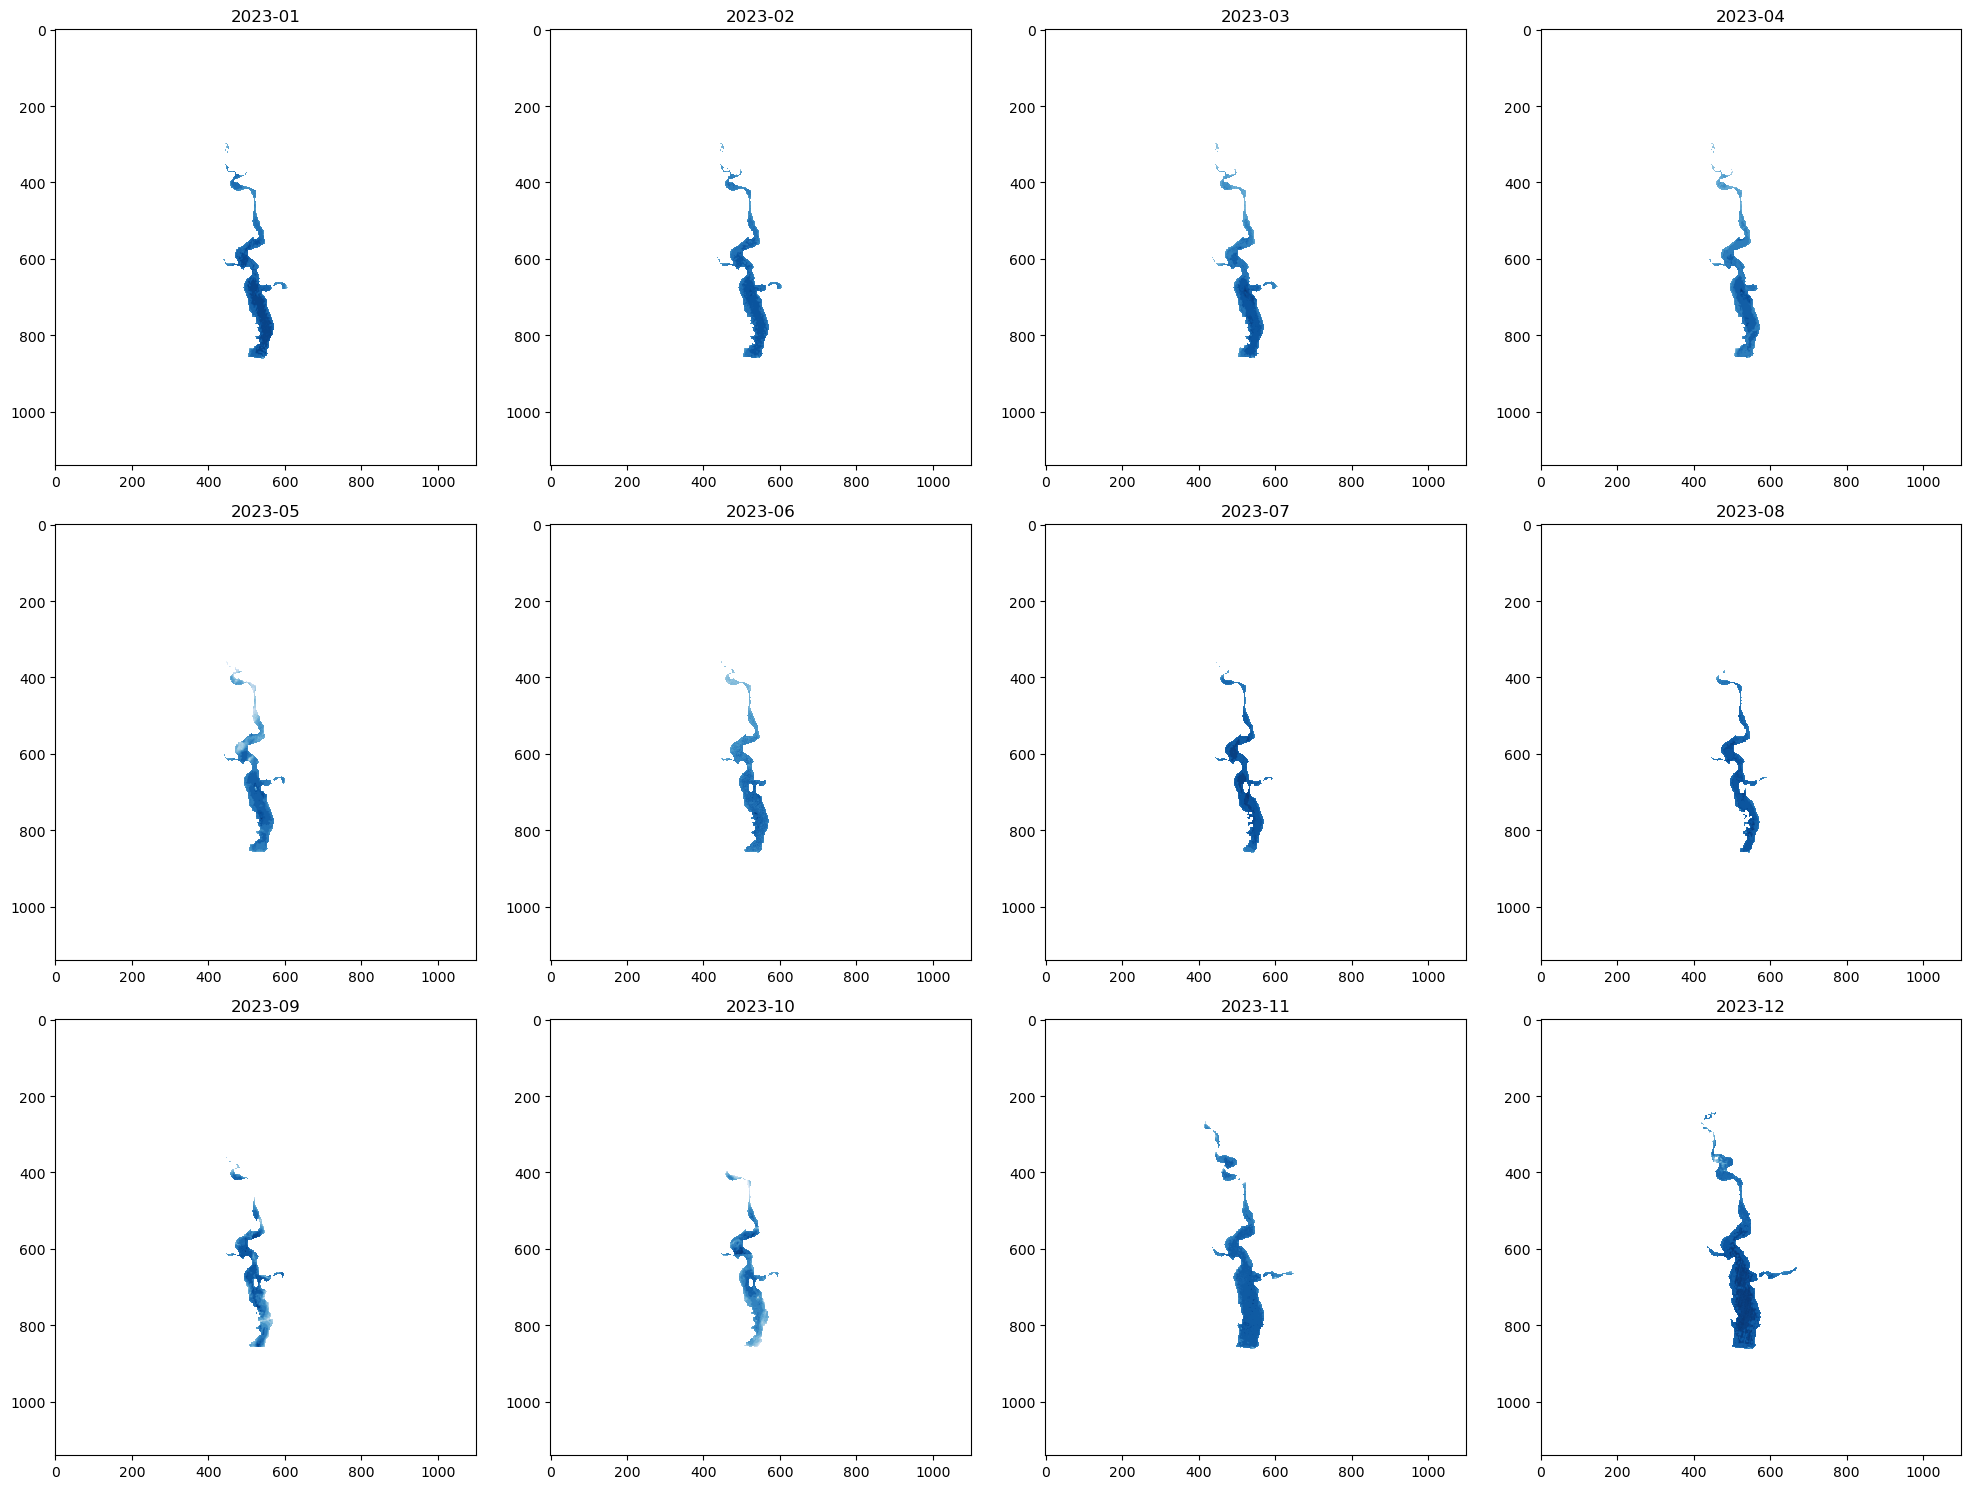

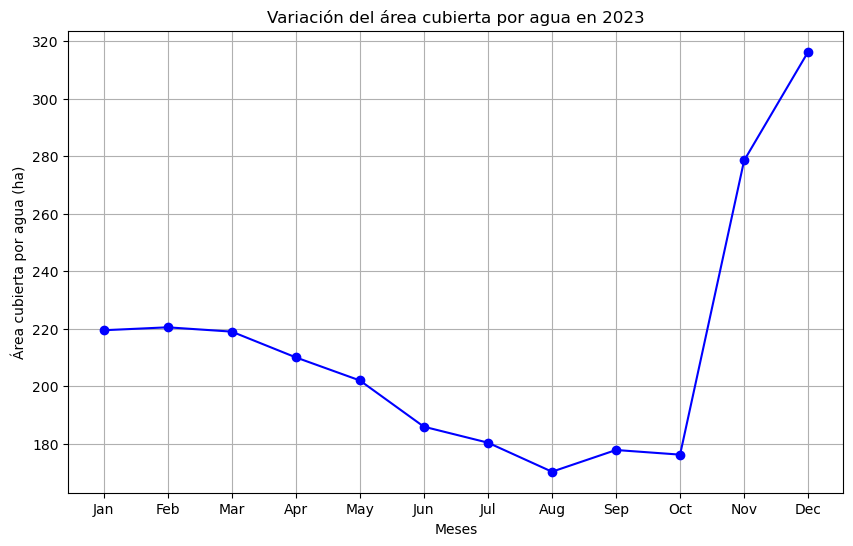

In [31]:
import os
from datetime import datetime, timedelta
from skimage import measure

# Evalscript para calcular NDWI
evalscript_ndwi = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B03", "B08"] // Green & NIR
            }],
            output: {
                bands: 2
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B03, sample.B08];
    }
"""

year = 2023
# Lista para almacenar las áreas de cada mes
areas = []

# Crear una figura y ejes para una cuadrícula de 3x4
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for month in range(1, 13):
    start_date = f"{year}-{month:02d}-01"
    if month == 12:
        end_date = f"{year + 1}-01-01"
    else:
        end_date = f"{year}-{month + 1:02d}-01"

    ndwi_request = SentinelHubRequest(
        evalscript=evalscript_ndwi,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url),
                time_interval=(start_date, end_date),
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=pardo_bbox,
    size=pardo_size,
    config=config,
    )

    ndwi_array = ndwi_request.get_data()
    image = ndwi_array[0]

    # Extraer las bandas
    Green = image[:, :, 0]
    NIR = image[:, :, 1]

    # Calcular el NDWI
    ndwi = (Green - NIR) / (Green + NIR)

    # Crear una máscara para delimitar las zonas de agua
    mask = ndwi < 1
    ndwi_masked = np.where(mask, ndwi, np.nan)

    # Etiquetar los objetos en la imagen binarizada
    labeled_ndwi, num_features = measure.label(mask, background=0, return_num=True)

    # Calcular las propiedades de los objetos
    properties = measure.regionprops(labeled_ndwi)

    # Definir un tamaño mínimo (esto depende del tamaño de tu embalse y de la resolución de la imagen)
    min_size = 1000  # Ajusta este valor según sea necesario

    # Crear una máscara para filtrar los objetos por tamaño
    large_objects_mask = np.zeros_like(mask, dtype=bool)

    for prop in properties:
        if prop.area >= min_size:
            large_objects_mask[labeled_ndwi == prop.label] = True

    # Aplicar la máscara a la imagen NDWI original
    filtered_ndwi = np.where(large_objects_mask, ndwi, np.nan)

    # Calcular el área total en metros cuadrados
    pixel_area = resolution ** 2  # Área de un píxel en metros cuadrados
    water_area = (np.sum(large_objects_mask) * pixel_area) / 10000
    areas.append(water_area)

    # Obtener los ejes correspondientes a la cuadrícula 3x4
    ax = axs[(month-1) // 4, (month-1) % 4]

    # Mostrar la imagen NDWI filtrada con el colormap personalizado
    cax = ax.imshow(filtered_ndwi, cmap="Blues")

    # Título
    ax.set_title(f'{start_date[:7]}')

    
# Ajustar el espacio entre los gráficos
plt.tight_layout()


# Mostrar la cuadrícula de imágenes
plt.show()

# Crear la serie temporal del área cubierta por agua
months = [datetime(year, month, 1).strftime("%b") for month in range(1, 13)]

plt.figure(figsize=(10, 6))
plt.plot(months, areas, marker='o', linestyle='-', color='b')
plt.xlabel('Meses')
plt.ylabel('Área cubierta por agua (ha)')
plt.title('Variación del área cubierta por agua en 2023')
plt.grid(True)

# Guardar la gráfica de la serie temporal
plt.savefig("monthly_images/NDWI_area_variation_2023.png")

# Mostrar la gráfica de la serie temporal
plt.show()

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, MosaickingOrder
from skimage import measure

# Asegúrate de estar utilizando el backend adecuado para Jupyter
%matplotlib notebook

# Evalscript para calcular NDWI
evalscript_ndwi = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B03", "B08"] // Green & NIR
            }],
            output: {
                bands: 2
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B03, sample.B08];
    }
"""

year = 2023
# Lista para almacenar las áreas de cada mes
areas = []
ndwi_images = []

for month in range(1, 13):
    start_date = f"{year}-{month:02d}-01"
    if month == 12:
        end_date = f"{year + 1}-01-01"
    else:
        end_date = f"{year}-{month + 1:02d}-01"

    ndwi_request = SentinelHubRequest(
        evalscript=evalscript_ndwi,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L1C.define_from(
                "s2l1c", service_url=config.sh_base_url),
                time_interval=(start_date, end_date),
                mosaicking_order=MosaickingOrder.LEAST_CC,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
        bbox=pardo_bbox,
        size=pardo_size,
        config=config,
    )

    ndwi_array = ndwi_request.get_data()
    image = ndwi_array[0]

    # Extraer las bandas
    Green = image[:, :, 0]
    NIR = image[:, :, 1]

    # Calcular el NDWI
    ndwi = (Green - NIR) / (Green + NIR)

    # Crear una máscara para delimitar las zonas de agua
    mask = ndwi < 1
    ndwi_masked = np.where(mask, ndwi, np.nan)

    # Etiquetar los objetos en la imagen binarizada
    labeled_ndwi, num_features = measure.label(mask, background=0, return_num=True)

    # Calcular las propiedades de los objetos
    properties = measure.regionprops(labeled_ndwi)

    # Definir un tamaño mínimo (esto depende del tamaño de tu embalse y de la resolución de la imagen)
    min_size = 1000  # Ajusta este valor según sea necesario

    # Crear una máscara para filtrar los objetos por tamaño
    large_objects_mask = np.zeros_like(mask, dtype=bool)

    for prop in properties:
        if (prop.area >= min_size):
            large_objects_mask[labeled_ndwi == prop.label] = True

    # Aplicar la máscara a la imagen NDWI original
    filtered_ndwi = np.where(large_objects_mask, ndwi, np.nan)

    # Calcular el área total en metros cuadrados
    resolution = 10  # Ajusta esto según la resolución de tu imagen en metros
    pixel_area = resolution ** 2  # Área de un píxel en metros cuadrados
    water_area = np.sum(large_objects_mask) * pixel_area
    areas.append(water_area)

    # Almacenar la imagen NDWI filtrada
    ndwi_images.append(filtered_ndwi)

# Crear la animación
fig, ax = plt.subplots(figsize=(8, 8))

def update(frame):
    ax.clear()
    ax.imshow(ndwi_images[frame], cmap="Blues")
    ax.set_title(f'NDWI Filtrado (Solo Embalse) - {year}-{frame+1:02d}')
    ax.axis('off')

ani = FuncAnimation(fig, update, frames=len(ndwi_images), repeat=True)

# Mostrar la animación en Jupyter
HTML(ani.to_jshtml())


/tmp/ipykernel_7698/84842412.py:67: RuntimeWarning: divide by zero encountered in divide
  ndwi = (Green - NIR) / (Green + NIR)
/tmp/ipykernel_7698/84842412.py:67: RuntimeWarning: divide by zero encountered in divide
  ndwi = (Green - NIR) / (Green + NIR)


<IPython.core.display.Javascript object>

/opt/conda/envs/sentinelhub/lib/python3.10/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(
